# Metodo Monte Carlo

Sotto il nome di *Monte Carlo* ricadono varie tecniche:
* generazione di numeri casuali secondo una distribuzione nota
* calcolo di integrali con l'uso di numeri casuali
* simulazione di processi casuali anche complessi

Cominciamo a vedere le applicazioni più semplici.

## Generazione di numeri casuali secondo una distribuzione voluta

Cominciamo da una distribuzione uniforme. Già abbiamo visto che è possibile passare da una distribuzione nell'ointervallo $[0, 1[$ ad una distribuzione nell'intervallo $[a, b\,[$ con una trasformazione lineare:

$x = a+ r\,(b-a)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

In [2]:
def plot_rnd(f, xmin, xmax, nbins=100, num = 100000):
    seq = [f() for i in range(num)]
    fig, ax = plt.subplots(figsize=(9,6))
    n, bins, patches = ax.hist(seq, nbins, density=True, range=(xmin, xmax))
    ax.set_xlabel('x')
    ax.set_ylabel('freq')
    plt.show()

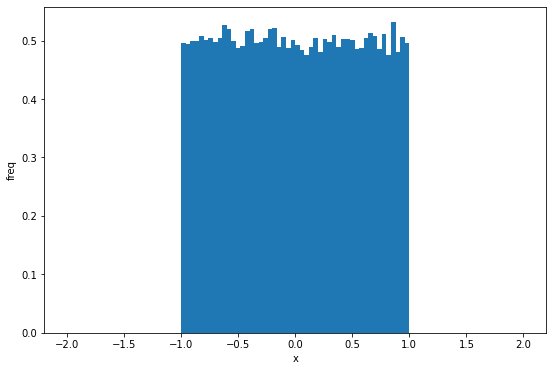

In [3]:
plot_rnd(lambda: -1+random.random()*2, -2, 2)

Per generare una sequenza di numeri interi con distribuzione di probabilità nota si può procedere come segue.
Di seguito un'implementazione, pensata per essere semplice da scrivere in python, ma sicuramente parecchio inefficiente. 

*D'altra parte, una maggiore efficienza può essere ottenuta solo in un linguaggio non interpretato ma compilato (es.: C, C++).*

In [4]:
from scipy.ndimage.interpolation import shift
val=np.array([1,2,3,4,5])
prob=np.array([0.1, 0.3, 0.3, 0.2, 0.1])
# normalize, just in case...
prob=prob/prob.sum()
prob_c=prob.cumsum()

In [5]:
prob_c

array([0.1, 0.4, 0.7, 0.9, 1. ])

In [6]:
prob_c=shift(prob_c, 1, cval=0)
prob_c

array([0. , 0.1, 0.4, 0.7, 0.9])

In [7]:
# assume r is the random number from 0 to 1
r = 0.5
print(prob_c)
print(prob_c<r)
print(val[prob_c<r])
print(val[prob_c<r][-1])

[0.  0.1 0.4 0.7 0.9]
[ True  True  True False False]
[1 2 3]
3


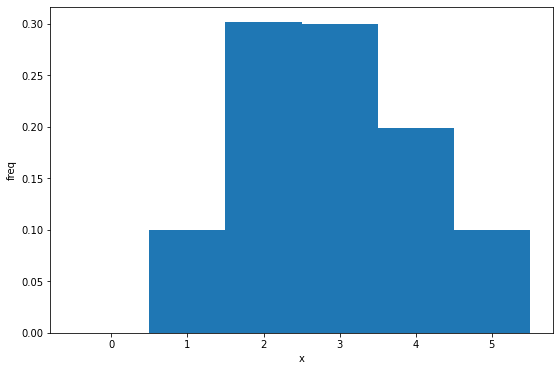

In [8]:
def rnd_discr():
    return val[prob_c<random.random()][-1]
plot_rnd(rnd_discr, -0.5, 5.5, 6)

La generazione casuale che abbiamo visto sopra si trova già implementata in [```choice```](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html).

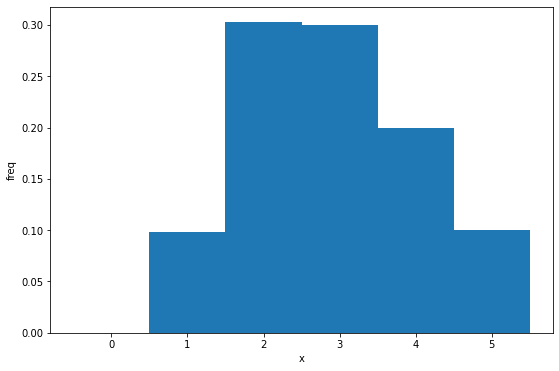

In [9]:
plot_rnd(lambda: np.random.choice(val, p=prob), -0.5, 5.5, 6)

Più in generale, se è nota una distribuzione, è possibile generare numeri casuali invertendo la sua distribuzione cumulativa. Questo approccio generalizza i due usati sopra.

In particolare, se definiamo:

$\displaystyle F(x) = \int_{-\infty}^xf(x^\prime)\,\mathrm{d}x^\prime$

e poniamo $F(x)=r$, dove $r$ è generato uniformemente in $[0, 1[$, possiamo scrivere:

$\displaystyle \frac{\mathrm{d}P}{\mathrm{d}F} = \frac{\mathrm{d}P}{\mathrm{d}r}=1$

Però possiamo anche scrivere:

$\displaystyle \frac{\mathrm{d}P}{\mathrm{d}x} = \frac{\mathrm{d}P}{\mathrm{d}F} \frac{\mathrm{d}F}{\mathrm{d}x} = \frac{\mathrm{d}P}{\mathrm{d}F} f(x) = f(x)$

Dobbiamo trovare quindi:

$x = F^{-1}(r)$

Proviamo ad applicarlo per generare secondo una distribuzione esponenziale:
    
$f(x) = \lambda e^{-\lambda x}$

Abbiamo:

$F(x) = 1 -e^{-\lambda x}$

Ponendo $F(x) = r$, invertiamo per ottenere $x$ da $r$:

$\displaystyle x= -\frac{1}{\lambda}\log(1-r)$

<span style="color:red">Attenzione: assicurarsi che l'argomento del logaritmo sia $>0$</span>

In [10]:
def rnd_exp():
    return -math.log(1-random.random())*1.5

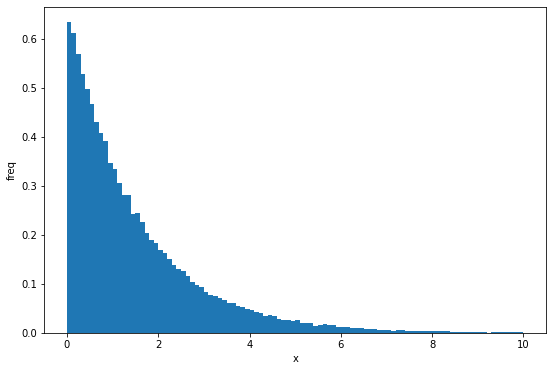

In [11]:
plot_rnd(rnd_exp, 0, 10)

## Distribuzione di punti su una sfera

Si possono generare punti in due dimensioni, $(\theta, \phi)$, tali che i punti siani distribuiti uniformemente su una sfera:

$\displaystyle \frac{\mathrm{d}P}{\mathrm{d}\Omega} = \frac{\mathrm{d}P}{\sin\theta\,\mathrm{d}\theta\,\mathrm{d}\phi}=k$ 

dove $k$ è una costante di normalizzazione.

Possiamo anche riscrivere:

$\displaystyle\frac{\mathrm{d}P}{\mathrm{d}\theta\,\mathrm{d}\phi}=f(\theta)\,g(\phi)= k\sin\theta$ 

Dove:

$f(\theta)=c_\theta\sin\theta$

$g(\phi) = c_\phi$

e $k=c_\theta c_\phi$.

Usando l'inversione della cumulativa, si ottiene:

$\displaystyle F(\theta) = \int_0^\theta c_\theta\sin\theta^\prime\,\mathrm{d}\theta^\prime = 
c_\theta\left[-\cos\theta^\prime\right]_0^\theta
= c_\theta(1-\cos\theta)$ 

$c_\theta$ deve essere tale che $F(\pi)=1$ quindi $c_\theta(1-\cos\pi)=1$, ossia $c_\theta = 1/2$.

$\displaystyle F(\theta) = r_\theta = \frac{1}{2}(1-\cos\theta)$

quindi:

$\displaystyle 2 r_\theta = 1-\cos\theta \implies 1-2r_\theta =\cos\theta$

$\theta = \mathrm{arccos}(1-2r_\theta)\in\, ]0, \pi]$

$\phi = 2\pi r_\phi\in [0, 2\pi[$

dove $r_\theta$ e $r_\phi$ sono generati uniformemente in $[0, 1[$.

In [12]:
def rnd_sph():
    return math.acos(1-2*random.random()), 2*math.pi*random.random()

In [13]:
rnd_sph()

(1.9147788887788124, 3.7695944699788964)

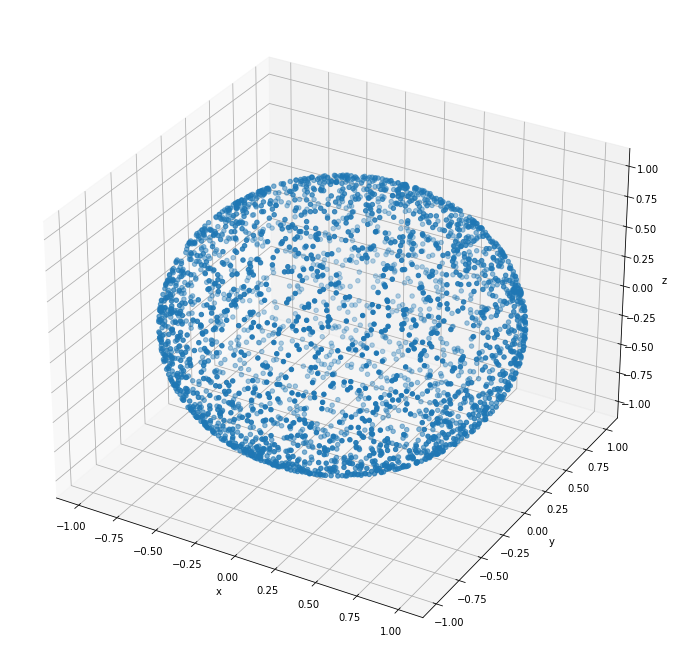

In [14]:
n = 3000
xs = np.empty(n)
ys = np.empty(n)
zs = np.empty(n)
for i in range(n):
    th, ph = rnd_sph()
    st, ct = math.sin(th), math.cos(th)
    sp, cp = math.sin(ph), math.cos(ph)
    xs[i], ys[i], zs[i] = st*cp, st*sp, ct
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs, marker='o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
fig.show()

## Distribuzione normale

Per generare una distribuzione gaussiana andrebbe invertita una error function, ma questo numericamente sarebbe inefficiente. 

Esiste una trasformazione che consente di trasformare una coppia di valori distribuiti iniformemente in una coppia di numeri distribuiti secondo una gaussiana, perché in due dimensioni l'integrazione si può fare in modo analitico. Una descrizione si trova <a href="https://www.alanzucconi.com/2015/09/16/how-to-sample-from-a-gaussian-distribution/">qui</a>. La trasformazione prende il nome di Box-Muller.

Esiste anche un algoritmo più efficiente detto <a href="https://heliosphan.org/zigguratalgorithm/zigguratalgorithm.html">Ziqqurat</a>.



## Campionamento Monte Carlo *hit or miss*

Questo metodo è più generale e non richiede inversioni di integrali al costo di essere meno efficiente.

In sostanza, vengono rigettati i punti sotto la curva che si vuole generare.

Usiamo la funzione:

$f(x)=x\,e^{-x}$

Che è normalizzata. Ma la normalizzazione non deve essere necessariamente imposta per applicare il metodo.


In [15]:
import time
def f_mc(x):
    return x*math.exp(-x)
f_mc_v=np.vectorize(f_mc)
xmin, xmax = 0, 10
ymax = 0.4
step=0.01
npts=20000

In [16]:
start_time = time.time()
xs=np.random.rand(npts)*(xmax-xmin)+xmin
ys=np.random.rand(npts)*ymax

In [17]:
hits=(ys<f_mc_v(xs))

In [18]:
print("\n- Executed in: %.4f seconds" % (time.time() - start_time))
cols=['red']*npts
for i in range(npts):
    if hits[i]: cols[i]='green'


- Executed in: 0.0280 seconds


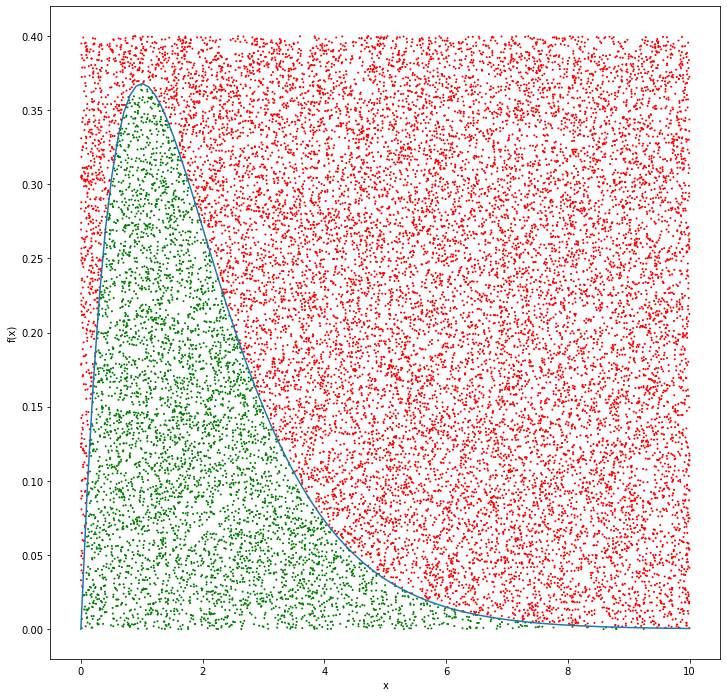

In [19]:
plt.figure(figsize=(12,12))
x=np.linspace(xmin, xmax, 100)
plt.plot(x,f_mc_v(x))
plt.scatter(xs,ys,c=cols,s=1)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [20]:
n_hit = len(hits[hits==True])
f_hit = n_hit/npts
print("n. hit:", n_hit)
print("eff:", f_hit)

n. hit: 4943
eff: 0.24715


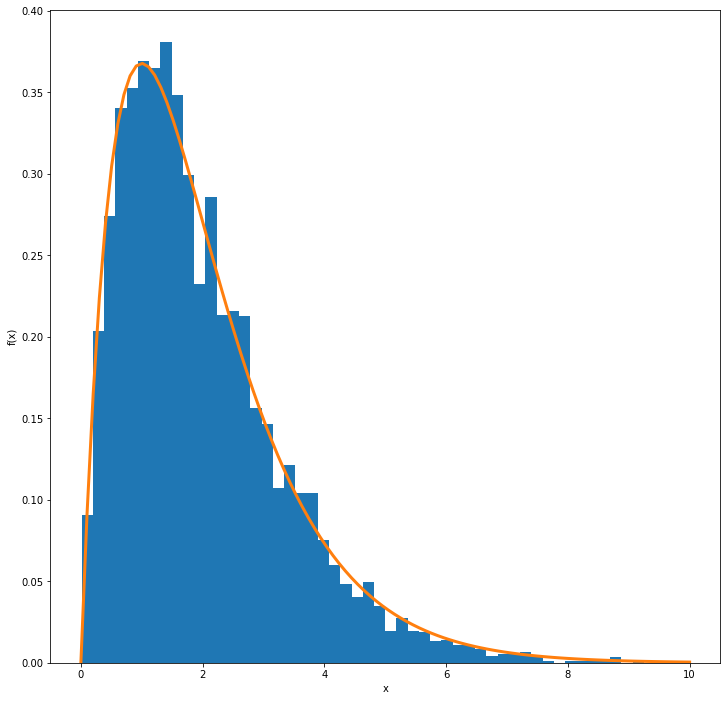

In [21]:
plt.figure(figsize=(12,12))
plt.hist(xs[hits],density=True,bins=50)
plt.plot(x,f_mc_v(x), linewidth=3)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

## Calcolo dell'integrale col metodo Monte Carlo

La frazione $f$ del numero di punti *hit* rappresenta la frazione dell'area sotto la curva rispetto all'area del rettangolo consiederato.

In [22]:
area = (xmax-xmin)*ymax
a_int = f_hit*area
print("area:", area)
print("eff:",f_hit)
print("integral:", a_int)

area: 4.0
eff: 0.24715
integral: 0.9886


L'incertezza può essere approssimativamente stimata dalla deviazione standard di una distribuzione binomiale:

$\displaystyle\sigma_f = \sqrt{\frac{f(1-f)}{N}}$

Va notato che questa incertezza **è indipendente dal numero di dimensioni del problema**. Per il calcolo di integrali a più dimensioni invece il tempo di calcolo più crescere notevolmente con altre tecniche di integrazioni.

In [23]:
sigma_f = math.sqrt(f_hit*(1-f_hit)/npts)
sigma_a = sigma_f*area
print("A = {:.3f} +/- {:.3f}".format(a_int,sigma_a))

A = 0.989 +/- 0.012


## Importance sampling

Il metodo hit or miss può essere inefficiente. Si può sezionare l'intervallo in diverse aree, e poi applicare il metodo hit or miss in ciascuna di esse.

In [24]:
from scipy.optimize import fminbound
partition = [0,2,4,6,8,10]
width = np.array([partition[i+1]-partition[i] for i in range(len(partition)-1)])
max_f = np.array([f_mc(fminbound(lambda x: -f_mc(x), partition[i], partition[i+1])) for i in range(len(partition)-1)])
prob = width*max_f
prob /= prob.sum()
idx = np.arange(len(prob))
print("width:", width)
print("max(f):", max_f)
print("prob:", prob)

width: [2 2 2 2 2]
max(f): [0.36787944 0.27067002 0.07326234 0.01487246 0.00268369]
prob: [0.50438114 0.37110216 0.10044633 0.02039089 0.00367948]


In [25]:
npts=20000
prob_c=prob.cumsum()
prob_c=shift(prob_c, 1, cval=0)
start_time = time.time()
xs = np.empty(npts)
ys = np.empty(npts)
hits = np.empty(npts)
cols = np.empty(npts)
for i in range(npts):
    j = idx[prob_c<random.random()][-1]
    x = random.uniform(partition[j], partition[j+1])
    y = random.uniform(0,max_f[j])
    hit = y<f_mc(x)
    xs[i], ys[i], hits[i] = x, y, hit
print("\n- Executed in: %.4f seconds" % (time.time() - start_time))
cols=['red']*npts
for i in range(npts):
    if hits[i]: cols[i]='green'


- Executed in: 0.1602 seconds


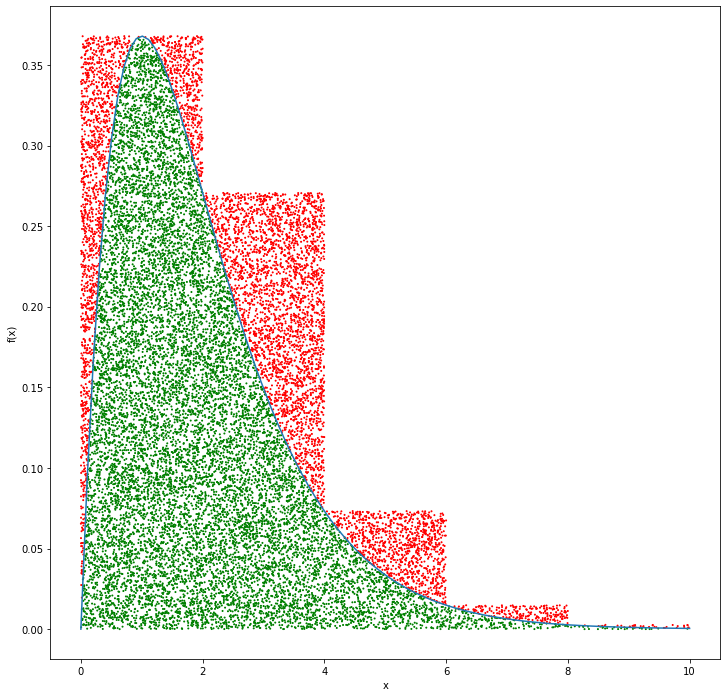

In [26]:
plt.figure(figsize=(12,12))
x=np.linspace(xmin, xmax, 100)
plt.plot(x,f_mc_v(x))
plt.scatter(xs,ys,c=cols,s=1)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [27]:
n_hit = len(hits[hits==True])
f_hit = n_hit/npts
print("n. hit:", n_hit)
print("eff:", f_hit)

n. hit: 13763
eff: 0.68815


Il calcolo dell'area va fatto con cautela perché la frazione dei casi va fatta sul totale dell'area selezionata.

In [28]:
area = (width*max_f).sum()
a_int = f_hit*area
print("area:", area)
print("eff:",f_hit)
print("integral:", a_int)

area: 1.45873591745837
eff: 0.68815
integral: 1.0038291215989774


L'incertezza, a parità di numero di estrazioni, sarà più piccola:

In [29]:
sigma_f = math.sqrt(f_hit*(1-f_hit)/npts)
sigma_a = sigma_f*area
print("A = {:.3f} +/- {:.3f}".format(a_int,sigma_a))

A = 1.004 +/- 0.005


In questo esercizio specifico l'algoritmo può essere poco vantaggioso, ma in $N$ dimensioni e con fuzioni molto piccate si possono raggiungere guadagni importanti.

## Importance sampling con una funzione continua

Nell'esempio precedente, abbiamo visto come partizionare l'intervallo di interesse per aumentare l'efficienza del campionamento.

L'*importance samplig* si può anche applicare utilizzando una funzione ausiliaria $g(x)$ che sia sempre maggiore della funzione $f(x)$ secondo la quale vogliamo generare il nostro campione casuale. In questo caso, si procede come segue:
1. si estrae un numero casuale $x$ secondo la funzione $g(x)$, per la quale assumiamo di avere un generatore casuale già implementato
* generiamo un numero uniforme tra $0$ e $g(x)$. Se questo è *minore* di $f(x)/g(x)$ il valore $x$ viene accettato, altrimenti viene rifiutato. Va notato che $f(x)/g(x)$ sarà sempre $<1$.

L'efficienza di questo medodo sarà pare al rapporto delle aree sotto le curve $f(x)$ e $g(x)$:

$\displaystyle \varepsilon = \frac{\int f(x)\,\mathrm{d}x}{\int g(x)\,\mathrm{d}x}$

### Esempio:
* generare numeri casuali secondo una distribuzione $f(x)\propto\sin^2\omega x\,e^{-\lambda x}$ usanto una variante dell'*importance sampling*

In [30]:
omega = 6
start_time = time.time()
xs = np.array([-math.log(random.random()) for i in range(npts)])
hs = [random.random() for i in range(npts)]
ys = [math.exp(-xs[i])*hs[i] for i in range(npts)]
hits = [(hs[i]<math.sin(omega*xs[i])**2) for i in range(npts)]
print("\n- Executed in: %.4f seconds" % (time.time() - start_time))
cols=['green' if hits[i] else 'red' for i in range(npts)]


- Executed in: 0.0462 seconds


<span style="color:blue">Va notato che i valori sono generato tra $0$ e $\infty$ (o almeno il più grande numero gestibile dal calcolatore), perché non c'è un limite superiore che è stato imposto nel codice!</span>

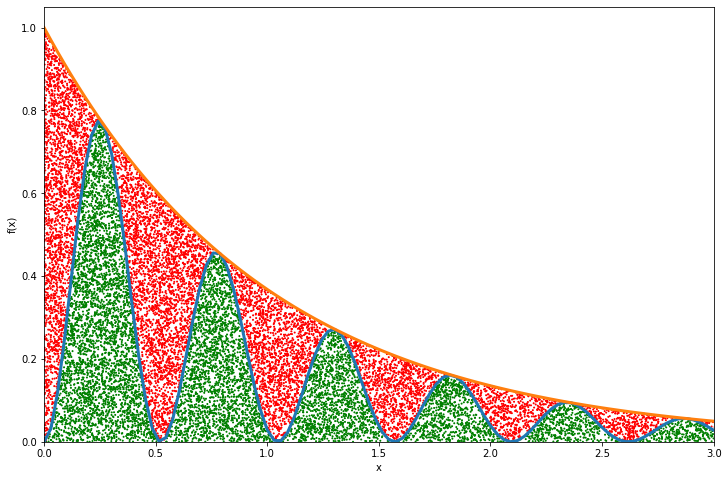

In [31]:
xrange = (0,3)
x=np.linspace(*xrange, 100)
def f_sim(x):
    return math.sin(omega*x)**2*math.exp(-x)
f_sim_v = np.vectorize(f_sim)
plt.figure(figsize=(12,8))
plt.plot(x, f_sim_v(x), linewidth=3)
plt.plot(x, np.exp(-x), linewidth=3)
plt.scatter(xs,ys,c=cols,s=1)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(0)
plt.xlim(*xrange)
plt.show()

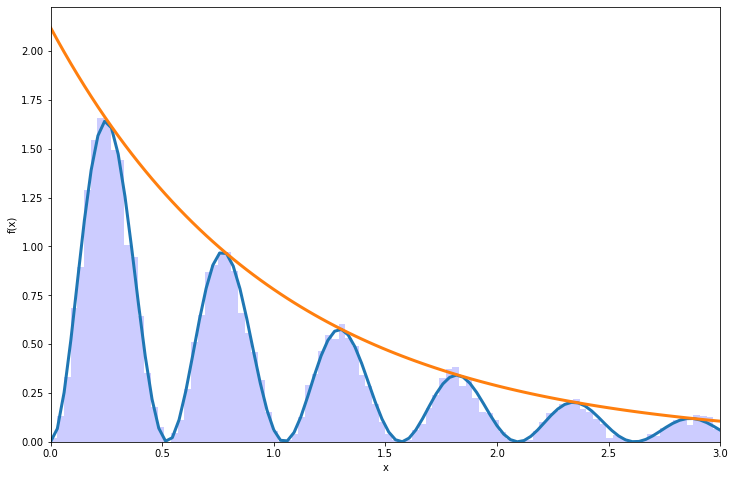

In [32]:
# the normalization factor has been determined in a heuristic way
c_norm= 2.12
plt.figure(figsize=(12,8))
plt.plot(x, c_norm*f_sim_v(x), linewidth=3)
plt.plot(x, c_norm*np.exp(-x), linewidth=3)
plt.hist(xs[hits],density=True,bins=100, range=xrange, color='blue', alpha=0.2)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim(0)
plt.xlim(*xrange)
plt.show()

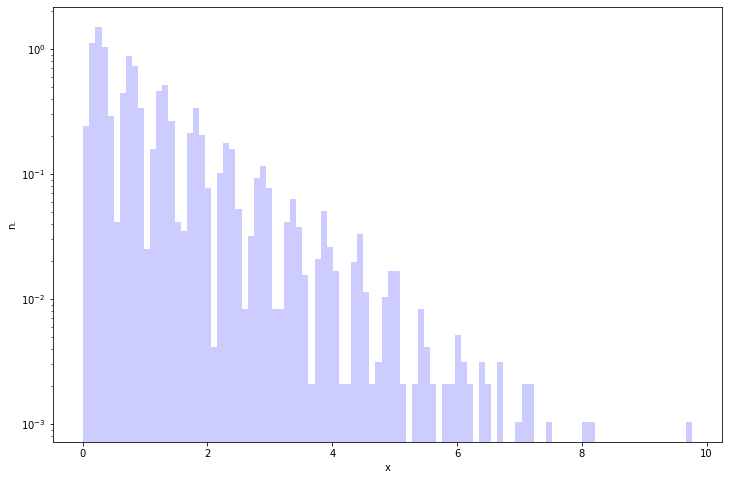

In [33]:
plt.figure(figsize=(12,8))
plt.hist(xs[hits],density=True,bins=100, color='blue', alpha=0.2)
plt.xlabel('x')
plt.ylabel('n.')
plt.yscale('log')
plt.show()

Scriviamo un'implementazione più semplice anche se lontana dallo stile ```numpy```.


- Executed in: 0.0217 seconds


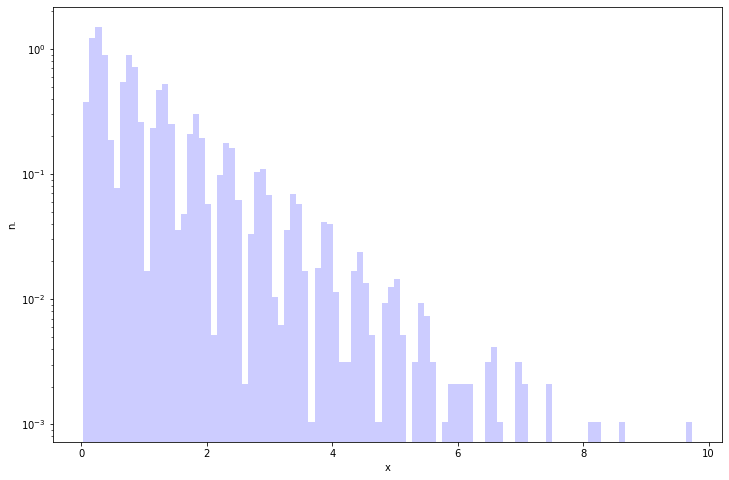

In [34]:
omega = 6
start_time = time.time()
xs = []
for i in range(npts):
    x = -math.log(random.random())
    h = random.random()
    if h<math.sin(omega*x)**2: 
        xs.append(x)
print("\n- Executed in: %.4f seconds" % (time.time() - start_time))
plt.figure(figsize=(12,8))
plt.hist(xs,density=True,bins=100, color='blue', alpha=0.2)
plt.xlabel('x')
plt.ylabel('n.')
plt.yscale('log')
plt.show()

# Spunti per esercizi

* calcolare $\pi$ con il metodo Monte Carlo, come area del quadrante di cerchio sotto la curva $f(x) = \sqrt{1-x^2}$.

* estendere il metodo *hit-or-miss* ad un caso bidimensionale di vostra scelta e calcolare il volume sotto la curva 3D

* scrivere un generatore di raggi cosmici procedendo in due passi:
    1. sapendo che la distribuzione angolare segue la legge $\mathrm{d}P(\theta,\phi)/\mathrm{d}\Omega = k \cos^2\theta$ con $0\leq\theta<\pi/2$, generare direzioni di provenienza che seguano questo andamento. Graficare su una sfera il risultato
    * generare un punto di impatto su un quadrato che giace su un piano orizzontale a quota $z=0$ con $0\leq x <l$, $0\leq y< l$
    * graficare in 3D i raggi cosmici in 3D usando [```plot```](https://matplotlib.org/2.0.2/examples/mplot3d/lines3d_demo.html) di ```matplotlob``` con gli estremi di un segmento in tre coordinate di lunghezza fissata. Si può usare [```quiver```](https://matplotlib.org/3.1.1/gallery/mplot3d/quiver3d.html).